# XGBoost - diabetes (Regression)
[ch5-advanced-xgboost-unveiled.ipynb](https://github.com/kyopark2014/ML-Algorithms/blob/main/xgboost/src/ch5-advanced-xgboost-unveiled.ipynb)

In [1]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd
import time

In [4]:
import xgboost as xgb
xgb.set_config(verbosity=0)

## Define Feature and Target

In [5]:
from sklearn import datasets
X, y = datasets.load_diabetes(return_X_y=True, as_frame=True)

In [6]:
pd.DataFrame(y).describe()

,target
count,442.000000
mean,152.133484
std,77.093005
min,25.000000
25%,87.000000
50%,140.500000
75%,211.500000
max,346.000000


In [7]:
pd.DataFrame(y).value_counts()

target
200.0     6
72.0      6
178.0     5
71.0      5
90.0      5
         ..
199.0     1
201.0     1
208.0     1
209.0     1
25.0      1
Length: 214, dtype: int64

In [8]:
pd.DataFrame(y).head()

,target
0,151.0
1,75.0
2,141.0
3,206.0
4,135.0


In [9]:
pd.DataFrame(X).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     442 non-null    float64
 1   sex     442 non-null    float64
 2   bmi     442 non-null    float64
 3   bp      442 non-null    float64
 4   s1      442 non-null    float64
 5   s2      442 non-null    float64
 6   s3      442 non-null    float64
 7   s4      442 non-null    float64
 8   s5      442 non-null    float64
 9   s6      442 non-null    float64
dtypes: float64(10)
memory usage: 34.7 KB


In [10]:
pd.DataFrame(y).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   target  442 non-null    float64
dtypes: float64(1)
memory usage: 3.6 KB


In [11]:
pd.DataFrame(X).isna().sum().sum()

0

## Regression Model Selection

In [12]:
from xgboost import XGBRegressor
from sklearn.model_selection import StratifiedKFold, cross_val_score

# kfold = KFold(n_splits=5, shuffle=True, random_state=2)
kfold = StratifiedKFold(n_splits=5)

def cross_validation(model):
    start = time.time()
    
    scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=kfold)
    
    rmse = np.sqrt(-scores)
    
    print('Cross Validation:')
    print('Elased time: %0.2fs' % (time.time()-start))
    print('RMSE:', np.round(rmse, 3))
    print('Avg. RMSE: %0.3f' % (rmse.mean()))

In [13]:
cross_validation(XGBRegressor(booster='gbtree'))

Cross Validation:
Elased time: 1.50s
RMSE: [67.236 65.503 59.636 67.445 59.142]
Avg. RMSE: 63.792


In [14]:
cross_validation(XGBRegressor(booster='gblinear'))

Cross Validation:
Elased time: 1.45s
RMSE: [   55.632 13664.114   135.263    60.611   527.573]
Avg. RMSE: 2888.639


In [15]:
cross_validation(XGBRegressor(booster='dart', one_drop=1))

Cross Validation:
Elased time: 2.22s
RMSE: [65.206 61.558 62.827 69.276 54.663]
Avg. RMSE: 62.706


In [20]:
from sklearn.linear_model import LinearRegression, LogisticRegression

cross_validation(LinearRegression())

Cross Validation:
Elased time: 0.02s
RMSE: [55.656 53.528 52.543 60.33  54.131]
Avg. RMSE: 55.238


In [21]:
from sklearn.linear_model import Lasso

cross_validation(Lasso())

Cross Validation:
Elased time: 0.02s
RMSE: [58.032 59.076 62.663 67.652 63.679]
Avg. RMSE: 62.220


In [22]:
from sklearn.linear_model import Ridge

cross_validation(Ridge())

Cross Validation:
Elased time: 0.04s
RMSE: [56.249 55.534 60.368 62.989 57.813]
Avg. RMSE: 58.591


In [23]:
from sklearn.ensemble import RandomForestRegressor

cross_validation(RandomForestRegressor())

Cross Validation:
Elased time: 1.05s
RMSE: [57.349 52.508 58.159 62.842 55.136]
Avg. RMSE: 57.199


## HPO

### Default

In [25]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Split train/test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

# define model
#model = XGBRegressor(booster='gbtree', objective='binary:logistic', 
#                        random_state=2, verbosity=0, use_label_encoder=False, n_jobs=-1)
model = XGBRegressor(booster='gbtree', random_state=2, verbosity=0, use_label_encoder=False, n_jobs=-1)

# default model accuacry 
def getAccuracy(model):
    start = time.time()

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    reg_mse = mean_squared_error(y_test, y_pred)
    reg_rmse = np.sqrt(reg_mse)

    print('Elapsed time: %0.2fs' % (time.time()-start))        
    print('RMSE: %0.3f' % (reg_rmse))

getAccuracy(model)

Elapsed time: 0.29s
RMSE: 64.182


## HPO: Randomized Search

In [26]:
from sklearn.model_selection import RandomizedSearchCV

def randomized_search(params, runs=20): 
    xgb = XGBRegressor(booster='gbtree', random_state=2, verbosity=0, use_label_encoder=False, n_jobs=-1)
    
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
    
    rand_reg = RandomizedSearchCV(xgb, params, cv=kfold, n_iter=runs, n_jobs=-1, random_state=2, scoring='neg_mean_squared_error')
    
    rand_reg.fit(X_train, y_train)    
    
    best_model = rand_reg.best_estimator_    
    
    best_params = rand_reg.best_params_
    print("best parameter:", best_params)
    
    best_score = rand_reg.best_score_
    rmse = np.sqrt(-best_score)
    print("best score: {:.3f}".format(rmse))
    
    return best_model

In [27]:
#        'n_estimators':[50, 100, 200],
#        'learning_rate':[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5],
#        'max_depth':[1, 2, 3, 5, 6, 8],
#        'gamma':[0, 0.01, 0.1, 0.5, 1, 2],
#        'min_child_weight':[1, 2, 3, 4, 5],
#        'subsample':[0.5, 0.7, 0.8, 0.9, 1],
#        'colsample_bytree':[0.5, 0.7, 0.8, 0.9, 1],  

start = time.time()

best_model = randomized_search(
    params={
        #'n_estimators':[50, 100, 200],
        #'learning_rate':[0.01, 0.1, 0.3, 0.5],
        #'max_depth':[1, 2, 3, 5, 7, 9],
        #'subsample':[0.5, 0.7, 0.8, 0.9, 1],
        'n_estimators':[100],
        'learning_rate':[0.1],
        'max_depth':[1],
        'subsample':[0.9],
        })

print('\nElapsed time: %0.2fs' % (time.time()-start))

best parameter: {'subsample': 0.9, 'n_estimators': 100, 'max_depth': 1, 'learning_rate': 0.1}
best score: 55.679

Elapsed time: 32.46s


In [28]:
best_model.get_params()

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'enable_categorical': False,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 1,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': -1,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 2,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 0.9,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': 0,
 'use_label_encoder': False}

## Evaluation

In [29]:
model = best_model

def model_estimation(model):    
    start = time.time()
    
    y_pred = model.predict(X_test)

    reg_mse = mean_squared_error(y_test, y_pred)
    reg_rmse = np.sqrt(reg_mse)

    print('Elapsed time: %0.2fs' % (time.time()-start))    
    
    #print('RMSE:', np.round(rmse, 3))
    print('RMSE: %0.3f' % (reg_rmse))
    
cross_validation(model)   
model_estimation(model)    

Cross Validation:
Elased time: 1.15s
RMSE: [55.916 52.47  56.163 60.333 53.213]
Avg. RMSE: 55.619
Elapsed time: 0.00s
RMSE: 57.265


## Feature Importances

Feature Importances:
[0.026246   0.02695159 0.23322964 0.10576426 0.02801274 0.02778028
 0.0667824  0.03198518 0.36405465 0.08919325]
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     |████████████████████████████████| 46 kB 7.6 MB/s             


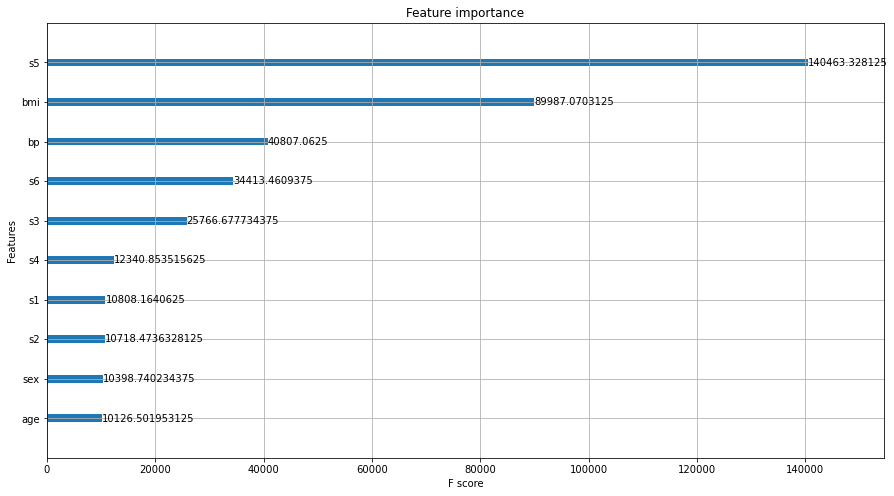

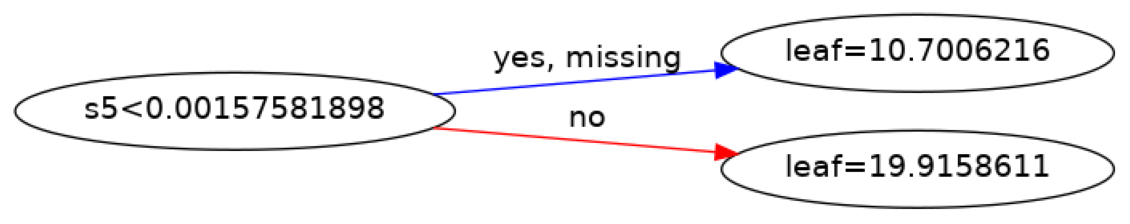

In [39]:
print('Feature Importances:')
print(model.feature_importances_)

import xgboost as xgb

feature_data = xgb.DMatrix(X_test)
model.get_booster().feature_names = feature_data.feature_names
model.get_booster().feature_types = feature_data.feature_types

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 8))
xgb.plot_importance(model, ax=ax, importance_type='gain')

!pip install graphviz

xgb.plot_tree(model, num_trees=0, rankdir='LR')

fig = plt.gcf()
fig.set_size_inches(20, 10)
plt.show()

### HPO - GridSearchCV

In [30]:
import time
from sklearn.model_selection import GridSearchCV

def grid_search(params, reg=XGBRegressor(booster='gblinear')):
    grid_reg = GridSearchCV(reg, params, scoring='neg_mean_squared_error', cv=kfold)
    start = time.time()
    
    grid_reg.fit(X, y)

    best_params = grid_reg.best_params_
    print("best parameter:", best_params)
    
    best_score = np.sqrt(-grid_reg.best_score_)
    print("best accuracy:", best_score)    
    print('Elased time: %0.2fs' % (time.time()-start))

In [31]:
grid_search(params={'reg_alpha':[0.001, 0.01, 0.1, 0.5, 1, 5]})

best parameter: {'reg_alpha': 0.1}
best accuracy: 55.40514154495419
Elased time: 7.62s


In [32]:
grid_search(params={'reg_lambda':[0.001, 0.01, 0.1, 0.5, 1, 5]})

best parameter: {'reg_lambda': 0.001}
best accuracy: 56.00845633859695
Elased time: 7.64s


In [33]:
grid_search(params={'feature_selector':['shuffle']})

best parameter: {'feature_selector': 'shuffle'}
best accuracy: 6585.072308615629
Elased time: 1.24s


In [34]:
grid_search(params={'feature_selector':['random', 'greedy', 'thrifty'], 
                    'updater':['coord_descent'] })

best parameter: {'feature_selector': 'greedy', 'updater': 'coord_descent'}
best accuracy: 55.29876446766565
Elased time: 3.94s


In [35]:
grid_search(params={'feature_selector':['greedy', 'thrifty'], 
                    'updater':['coord_descent'], 'top_k':[3, 5, 7, 9]})

best parameter: {'feature_selector': 'greedy', 'top_k': 9, 'updater': 'coord_descent'}
best accuracy: 55.29876446766565
Elased time: 10.10s


In [36]:
param_grid = [{'updater':['shotgun'],
               'feature_selector':['cyclic', 'shuffle']},
              {'updater':['coord_descent'],
               'feature_selector':['random', 'greedy', 'thrifty']}]
grid_search(params=param_grid)

best parameter: {'feature_selector': 'greedy', 'updater': 'coord_descent'}
best accuracy: 55.29876446766565
Elased time: 6.42s


In [37]:
X = np.arange(1,100)
np.random.seed(2) 
y = []
for i in X:
    y.append(i*np.random.uniform(-0.2, 0.2))
y = np.array(y)
X = X.reshape(X.shape[0], 1)
y = y.reshape(y.shape[0], 1)

Matplotlib is building the font cache; this may take a moment.


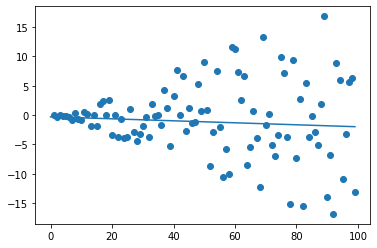

In [38]:
import matplotlib.pyplot as plt

xgbr = XGBRegressor(booster='gblinear')
xgbr.fit(X, y)

plt.scatter(X, y)
plt.plot((0, 99), (xgbr.intercept_, xgbr.coef_*99+xgbr.intercept_))
plt.show()